In [28]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Training our VGGFace Model Using Transfer Learning VGG16

### Loading the VGG16 Model

In [29]:
from keras.applications import vgg16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224 

In [30]:
#Loads the VGG16 model 
conv_base = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

In [31]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Inpsecting each layer

In [32]:
# Let's print our layers 
for (i,layer) in enumerate(conv_base.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


### Let's make a function that returns our FC Head

In [33]:
def addTopModel(bottom_model):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(1,activation='sigmoid')(top_model)
    return top_model

In [34]:
# addTopModel(conv_base)

#### re-sizing the image to 64 x 64

In [35]:
from keras.applications import VGG16

for layer in conv_base.layers:
    layer.trainable = True
    
# Let's print our layers 
for (i,layer) in enumerate(conv_base.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer True
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


In [36]:
FC_Head = addTopModel(conv_base)

model = Model(inputs=conv_base.input, outputs=FC_Head)

print(model.summary())
print('Number of hidden layer = {}'.format(len(model.layers)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [38]:
nb_train_samples = 636
nb_validation_samples = 212
epochs = 100
batch_size = 16

In [37]:
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_data_dir = "../datasets/split/GB_train/"
val_data_dir = "../datasets/split/GB_val/"
test_data_dir = "../datasets/split/GB_test/"


train_datagen = ImageDataGenerator(rescale = 1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size = (img_rows, img_cols),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')
val_set = test_datagen.flow_from_directory(val_data_dir,
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 636 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


### Trainning Begins

In [50]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
                   
checkpoint = ModelCheckpoint("./saved/big_dataset_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              patience = 3,
                              min_lr=0.00000001,
                              verbose = 1,
                              min_delta = 0.00001)

# we put our call backs into a callback list
callbacks = [checkpoint, earlystop,reduce_lr]

# Note we use a small learning rate so that we can fine-tune the trained model
model.compile(optimizer=RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy','mse','mae','cosine'])


history = model.fit_generator(
    training_set,
    # set steps per epoch equal to the number of training images
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = val_set,
    validation_steps = nb_validation_samples // batch_size)

model.save("./saved/big_dataset_vgg.h5")

Epoch 1/100
39/39 [==============================] - 1259s 32s/step - loss: 0.0915 - acc: 0.9872 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0168 - cosine_proximity: -0.4845 - val_loss: 0.0225 - val_acc: 0.9898 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0119 - val_cosine_proximity: -0.5510

Epoch 00001: val_loss improved from inf to 0.02246, saving model to ./saved/big_dataset_vgg.h5
Epoch 2/100
39/39 [==============================] - 1314s 34s/step - loss: 0.0193 - acc: 0.9936 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0087 - cosine_proximity: -0.4915 - val_loss: 0.1352 - val_acc: 0.9745 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.0252 - val_cosine_proximity: -0.5459

Epoch 00002: val_loss did not improve from 0.02246
Epoch 3/100
39/39 [==============================] - 1253s 32s/step - loss: 0.0286 - acc: 0.9909 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0130 - cosine_proximity: -0.4936 - val_loss: 0.0877 - val_acc

Epoch 1/100
39/39 [==============================] - 1250s 32s/step - loss: 0.6345 - acc: 0.6266 - mean_squared_error: 0.2216 - mean_absolute_error: 0.4498 - cosine_proximity: -0.4808 - val_loss: 0.5525 - val_acc: 0.6587 - val_mean_squared_error: 0.1893 - val_mean_absolute_error: 0.3844 - val_cosine_proximity: -0.5481

Epoch 00001: val_loss improved from inf to 0.55250, saving model to ./saved/big_dataset_vgg.h5
Epoch 2/100
39/39 [==============================] - 1221s 31s/step - loss: 0.3750 - acc: 0.8408 - mean_squared_error: 0.1171 - mean_absolute_error: 0.2639 - cosine_proximity: -0.4760 - val_loss: 0.2970 - val_acc: 0.8724 - val_mean_squared_error: 0.0933 - val_mean_absolute_error: 0.1774 - val_cosine_proximity: -0.5357

Epoch 00002: val_loss improved from 0.55250 to 0.29699, saving model to ./saved/big_dataset_vgg.h5
Epoch 3/100
39/39 [==============================] - 1222s 31s/step - loss: 0.1917 - acc: 0.9241 - mean_squared_error: 0.0537 - mean_absolute_error: 0.1154 - cosine

Epoch 00021: early stopping


##### Evaluating based on test set

In [51]:
model.evaluate_generator(test_set, steps=50)

[0.05594987761614515,
 0.9813829787234043,
 0.015239775997107104,
 0.020740008025603992,
 -0.5159574017879811]

In [52]:
model.metrics_names

['loss',
 'acc',
 'mean_squared_error',
 'mean_absolute_error',
 'cosine_proximity']

### Visual Look of our custom model

In [53]:
# %matplotlib inline
# import keras
# from keras.models import Sequential
# from keras.utils.vis_utils import plot_model
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import numpy as np

# plot_model(model, to_file='vgg_bigdataset.png', show_shapes=True, show_layer_names=True)
# img = mpimg.imread('vgg_bigdataset.png')
# plt.figure(figsize=(100,70))
# imgplot = plt.imshow(img) 

### Performance Analysis

In [54]:
import matplotlib.pyplot as plt

In [55]:
# plt.style.available

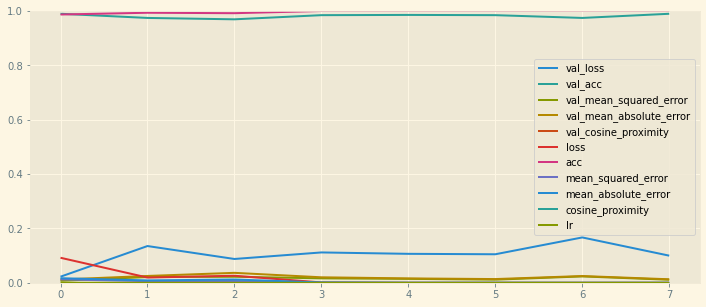

In [56]:
import pandas as pd

plt.style.use('Solarize_Light2')
plt.rcParams['figure.figsize'] = [8, 4]

pd.DataFrame(history.history).plot(figsize=(12,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

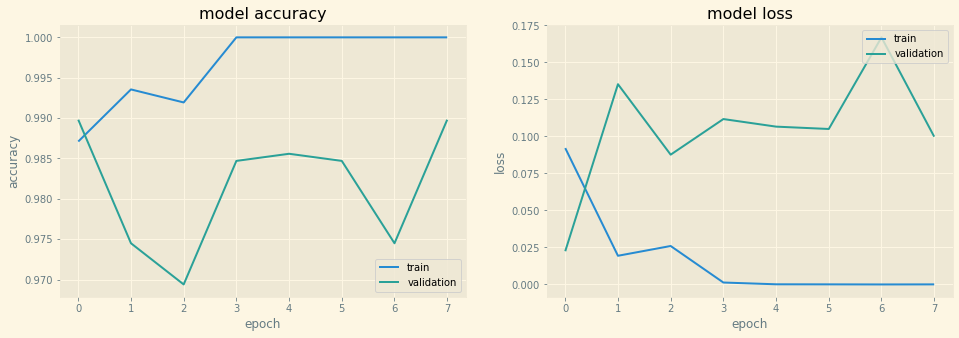

In [57]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

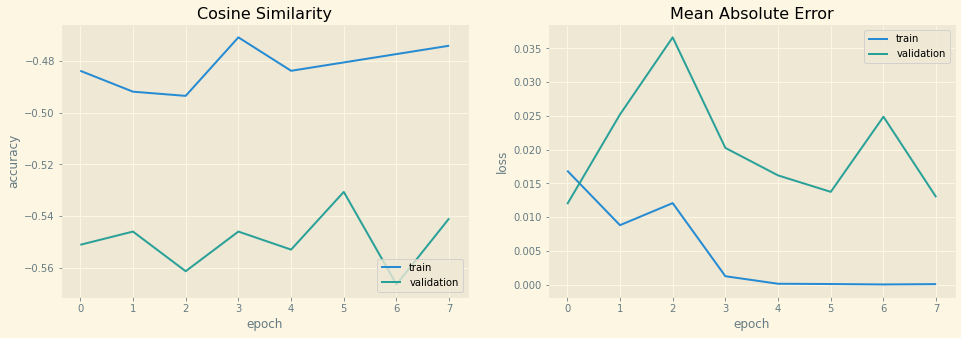

In [58]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['cosine_proximity'])
plt.plot(history.history['val_cosine_proximity'])
plt.title('Cosine Similarity')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

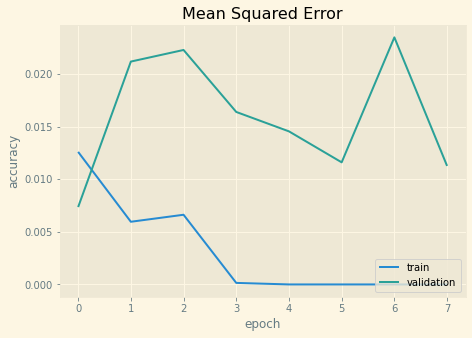

In [59]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Mean Squared Error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')